In [1]:
from datetime import datetime, timedelta
ipynb_run_start = datetime.now()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from workalendar.europe import UnitedKingdom
from pandas.tseries.offsets import DateOffset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix

from tslearn.clustering import TimeSeriesKMeans

# Домашнее задание №1: `Кластеризация временных рядов`
***Скажи мне, кто твой друг, и я скажу, какой у тебя `clustering coefficient`***

## Цель: выявить группы потребителей с похожими паттернами (шаблонами поведенческой активности) покупок на основе временных рядов их транзакций
В этом домашнем задании предлагается провести исследование по кластеризации временных рядов, основанное на данных о потребительском поведении из скачиваемого в Интернет датасета https://archive.ics.uci.edu/dataset/352/online+retail 

**NB!:** в данном ноутбуке предполагается, что датасет уже скачан из интернета и лежит в папке data в директории запуска ноутбука

# Чтение данных из файла, пересохранение в CSV и первый взгляд на поля

## для ускорения перезапусков пересохраним в csv и не будем больше парсить из эксель

In [3]:
# раскомментировать при первом запуске:
raw_df = pd.read_excel('data/Online Retail.xlsx', dtype={'CustomerID':'object'})  # dtype на поле добавлен позже
raw_df.to_csv('data/Online Retail.csv', sep=';', index=False)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


## при повторных запусках выполнение начинается тут:

In [4]:
raw_df = pd.read_csv('data/Online Retail.csv', sep=';', dtype={'CustomerID':'object'})   # dtype на поле добавлен позже
raw_df.InvoiceDate = pd.to_datetime(raw_df.InvoiceDate)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


## посмотрим 10 случайных записей

In [5]:
raw_df.sample(n=10,axis=0,random_state=17)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
192056,553389,37476,CONDIMENT TRAY 4 BOWLS AND 4 SPOONS,1,2011-05-16 16:37:00,8.29,NaN,United Kingdom
97588,544646,85099C,JUMBO BAG BAROQUE BLACK WHITE,2,2011-02-22 12:06:00,1.95,17075,United Kingdom
17437,537762,22835,HOT WATER BOTTLE I AM SO POORLY,4,2010-12-08 12:01:00,4.65,16558,United Kingdom
379379,569691,21165,BEWARE OF THE CAT METAL SIGN,12,2011-10-05 15:09:00,1.69,18223,United Kingdom
260043,559796,20677,PINK POLKADOT BOWL,2,2011-07-12 13:30:00,2.46,NaN,United Kingdom
320083,564962,47504H,ENGLISH ROSE SPIRIT LEVEL,2,2011-08-31 14:35:00,0.79,17777,United Kingdom
276137,561033,22619,SET OF 6 SOLDIER SKITTLES,4,2011-07-24 11:40:00,3.75,14443,United Kingdom
29279,C538723,22094,RED RETROSPOT TISSUE BOX,-5,2010-12-14 11:12:00,1.25,12434,Australia
245220,558614,21380,WOODEN HAPPY BIRTHDAY GARLAND,1,2011-06-30 15:56:00,5.79,NaN,United Kingdom
187884,553011,22386,JUMBO BAG PINK POLKADOT,10,2011-05-12 17:03:00,2.08,14390,United Kingdom


In [6]:
print('FYI: ПРОПУСКИ ДАННЫХ ЕСТЬ В ПОЛЯХ:', [fld for fld in raw_df.columns if raw_df[fld].isna().sum() > 0])

FYI: ПРОПУСКИ ДАННЫХ ЕСТЬ В ПОЛЯХ: ['Description', 'CustomerID']


## первые ВЫВОДЫ:
1) Одна запись, видимо, представляет одну позицию счета `InvoiceNo`:
*  время выставления счета, клиент,
*  код продукта, краткое описание продукта,
*  количество, цена за штуку,
*  (**NB!:** нет цены всей позиции, равной произведению количества и цены за штуку);

2) Есть отрицательные количества - возможно, это возвраты;
3) Клиент указан не всегда (3 из 10 в случайной выборке NaN) - проверить возможность восстановления в пределах общего `InvoiceNo`;
4) Разные страны (сетевой магазин?) - уникальность счета обеспечивается буквенным префиксом, а вот есть ли кросс-граничная уникальность клиента(идентификаторы всегда целые числа одной длины!)?   Тоже проверить, хотя, это интернет-магазин;
5) Наличие краткого описания продукта позволяет дополнить кластеризацию LSA-анализом и векторизовать предпочтения по типам продуктов (а не только по кодам и временным паттернам);
6) Идентификаторы счета, продукта и клиента представляют, в основном, целые числа, предположительно одной разрядности (в пределах поля - счет 6 цифр, продукт и клиент по 5 цифр), однако в редких случаях счет имеет буквенный префикс (предположительно вне UK), а продукт - буквенный суффикс, неясной пока семантики.  Номер клиента всегда целое, но не всегда присутствует, поэтому при чтении данных без принудительного указания `dtype={'CustomerID':'object'}` конвертивровался во float, с добавлением десятичной точки ко всем идентификаторам, поэтому в этом месте мы вернулись в чтению данных и добавили параметр dtype для поля клиента;
7) Разрадность всех идентификаторов неправдоподобно мала для реальной жизни, но тут мы списываем на то, что пример данных игровой;
8) Время счета не содержит часового пояса, а вот страны разделены на полсуток по долготе - генерация фич по суточной сезонности может быть так себе, да и у недельной сезонности может не быть четких границ.

## полные дубликаты

In [7]:
print('FYI: ВСЕГО', raw_df.duplicated(keep=False).sum(), 'ЗАПИСЕЙ ('+
                    str(round(raw_df.duplicated(keep=False).sum()/raw_df.shape[0]*100,1))+ 
      '%) ИМЕЮТ НЕ МЕНЕЕ ОДНОГО ПОЛНОГО ДУБЛИКАТА!')

FYI: ВСЕГО 10147 ЗАПИСЕЙ (1.9%) ИМЕЮТ НЕ МЕНЕЕ ОДНОГО ПОЛНОГО ДУБЛИКАТА!


### ПРИЧИНАМИ полных дубликатов могут быть: 
1) пропуски значений полей - но не в нашем случае, так как пропуски только в описании продукта, которое предполагается однозначно задается кодом продукта, и в номере клиента, который также однозначно соответствует номеру чека;
2) семантика записей - это как раз наш случай, так как записи есть позиции чека и возможно, например, поштучное включение нескольких одинаковых продуктов в счет - при пробивании на физической кассе это вообще типичная ситуация, в интернет магазине пореже, но тоже возможно в редких ситуациях (например, при раскидывании маркетинговых скидок, накопленных баллов и пр) - в этом случае дубликаты нужно агрегировать;
3) потеря транзакционности при передаче информации о покупке из удаленных магазинов или от разъездных курьеров или при оплате картами - в этом случае дубликаты нужно удалять;
4) фрод

### чтобы не умножать гипотезы, исследуем полные дубликаты

In [8]:
doubles_df = raw_df[raw_df.duplicated(keep=False)].copy('deep')
doubles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10147 entries, 485 to 541701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10147 non-null  object        
 1   StockCode    10147 non-null  object        
 2   Description  10147 non-null  object        
 3   Quantity     10147 non-null  int64         
 4   InvoiceDate  10147 non-null  datetime64[ns]
 5   UnitPrice    10147 non-null  float64       
 6   CustomerID   10062 non-null  object        
 7   Country      10147 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 713.5+ KB


In [9]:
doubles_df.sample(n=10,axis=0,random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
409817,572074,21027,NINJA RABBIT PINK,2,2011-10-20 13:54:00,1.25,16284,United Kingdom
104596,545188,22535,MAGIC DRAWING SLATE BUNNIES,1,2011-02-28 15:19:00,0.42,14056,United Kingdom
172738,551558,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-05-03 10:41:00,0.55,17841,United Kingdom
468352,576463,22748,POPPY'S PLAYHOUSE KITCHEN,1,2011-11-15 11:37:00,2.10,17974,United Kingdom
483432,577503,21034,REX CASH+CARRY JUMBO SHOPPER,1,2011-11-20 12:34:00,0.95,18110,United Kingdom
29743,538826,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,2010-12-14 12:58:00,3.75,12370,Cyprus
8705,537144,21882,SKULLS TAPE,1,2010-12-05 13:00:00,0.65,15880,United Kingdom
213196,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom
387564,570333,21169,YOU'RE CONFUSING ME METAL SIGN,1,2011-10-10 12:19:00,1.69,18126,United Kingdom
92099,544177,21754,HOME BUILDING BLOCK WORD,3,2011-02-16 14:27:00,5.95,13001,United Kingdom


#### сравним статистику числовых полей у дубликатов и в целом

In [10]:
view_num = raw_df.describe().join(doubles_df.describe(), lsuffix='_all', rsuffix='_dbl')
view_num = view_num[sorted(view_num.columns)]
view_num

,InvoiceDate_all,InvoiceDate_dbl,Quantity_all,Quantity_dbl,UnitPrice_all,UnitPrice_dbl
count,541909,10147,541909.000000,10147.000000,541909.000000,10147.000000
mean,2011-07-04 13:34:57.156386048,2011-07-24 12:17:00.585394688,9.552250,2.651621,4.611114,2.413383
min,2010-12-01 08:26:00,2010-12-01 11:45:00,-80995.000000,-1296.000000,-11062.060000,0.000000
25%,2011-03-28 11:34:00,2011-04-04 12:01:00,1.000000,1.000000,1.250000,0.950000
50%,2011-07-19 17:17:00,2011-09-12 13:43:00,3.000000,1.000000,2.080000,1.650000
75%,2011-10-19 11:27:00,2011-11-09 13:46:00,10.000000,2.000000,4.130000,2.950000
max,2011-12-09 12:50:00,2011-12-09 11:34:00,80995.000000,1440.000000,38970.000000,19.950000
std,NaN,NaN,218.081158,28.641413,96.759853,2.269688


#### сравним временные распределения дубликатов и в целом

In [11]:
wbins = [pd.to_datetime('2010-12-01') + timedelta(days=7)*w for w in range(55)]
ticks = [pd.Timestamp('2010-12-01') + DateOffset(months=i) for i in range(14)]
wbins[-1], ticks[-1]                         # контролируем последнее значение

(Timestamp('2011-12-14 00:00:00'), Timestamp('2012-01-01 00:00:00'))

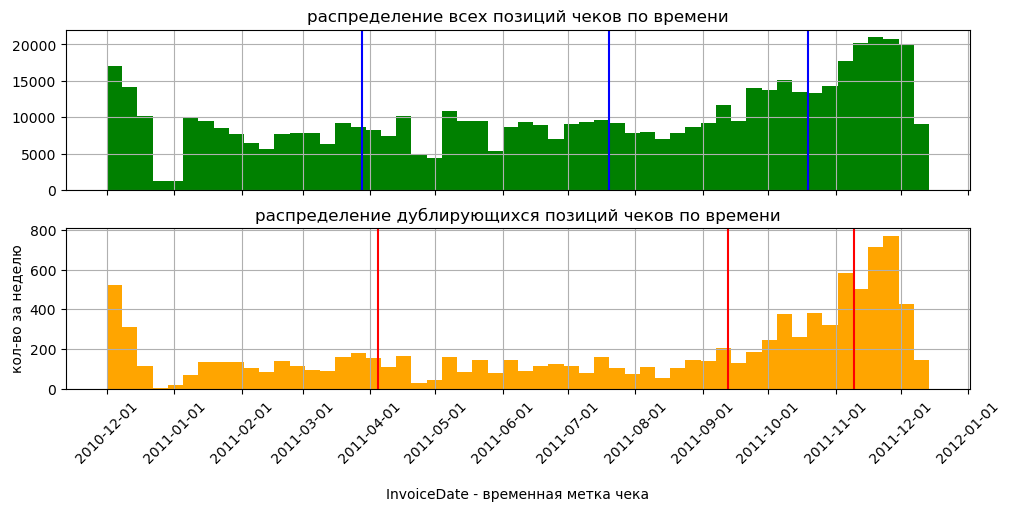

In [12]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,5), layout='constrained', sharex=True)

ax1.hist(raw_df.InvoiceDate,     color='green',  bins=wbins)
ax2.hist(doubles_df.InvoiceDate, color='orange', bins=wbins)

ax2.set_xticks(ticks, labels=[str(ts).split()[0] for ts in ticks], rotation=45)
ax1.grid()
ax2.grid()
ax1.set_title('распределение всех позиций чеков по времени')
ax2.set_title('распределение дублирующихся позиций чеков по времени')
ax2.set_ylabel('кол-во за неделю')
ax2.set_xlabel('\nInvoiceDate - временная метка чека')

for ts in view_num.iloc[3:6,0]:
    ax1.axvline(ts, color='blue')
for ts in view_num.iloc[3:6,1]:
    ax2.axvline(ts, color='red')

plt.show()

#### сравним статистику категориального поля `Country` у дубликатов и в целом

In [13]:
view_cat = pd.DataFrame(raw_df.Country.value_counts()).join(doubles_df.Country.value_counts(), lsuffix='_all', rsuffix='_dbl')
view_cat['share_of_total_alls_%'] = (view_cat.count_all / (view_cat.count_all.sum()) * 100).map(lambda x: round(x,2))
view_cat['share_of_total_dbls_%'] = (view_cat.count_dbl / (view_cat.count_dbl.sum()) * 100).map(lambda x: round(x,2))
view_cat['ratio_of_shares_dbl2all'] = view_cat['share_of_total_dbls_%'] / view_cat['share_of_total_alls_%']

print('\nFYI: ЕСЛИ ПРЕДПОЛОЖИТЬ ФРОДОВЫЙ ХАРАКТЕР ПОЛНЫХ ДУПЛИКАТОВ, ТО ВОТ ЛИСТ ГЛАВНЫХ ЖУЛИКОВ:\n')
view_cat.sort_values('ratio_of_shares_dbl2all', ascending=False).dropna()


FYI: ЕСЛИ ПРЕДПОЛОЖИТЬ ФРОДОВЫЙ ХАРАКТЕР ПОЛНЫХ ДУПЛИКАТОВ, ТО ВОТ ЛИСТ ГЛАВНЫХ ЖУЛИКОВ:



,count_all,count_dbl,share_of_total_alls_%,share_of_total_dbls_%,ratio_of_shares_dbl2all
Country,,,,,
Cyprus,622,21.0,0.11,0.21,1.909091
Hong Kong,288,8.0,0.05,0.08,1.600000
Israel,297,6.0,0.05,0.06,1.200000
United Kingdom,495478,9969.0,91.43,98.25,1.074593
Unspecified,446,8.0,0.08,0.08,1.000000
Portugal,1519,17.0,0.28,0.17,0.607143
Switzerland,2002,16.0,0.37,0.16,0.432432
Sweden,462,2.0,0.09,0.02,0.222222
Spain,2533,10.0,0.47,0.10,0.212766


### ВЫВОДЫ ПО ИССЛЕДОВАНИЮ ДУБЛИКАТОВ:
1) **Дубликаты проявляются в позиции преимущественно из 1-2 шт по товарам с ценой, строго ограниченной 20 (фунтами?) за штуку**
2) **В отличие от всех позиций цена за штуку для дубликатов не может быть отрицательной, но может быть равной нулю - что значат нулевые и отрицательные цены пока не ясно**
3) **Кол-ва могут быть отрицательными и во всех, и у дубликатов - предположительно, это возврат позиций**
4) **Чем спокойнее сезонный уровень торговли, тем меньше доля дубликатов - поэтому перцентили дубликатов сдвинуты относительно перцентилей всех позиций ближе к концу года**
5) **Дубликаты есть не во всех странах, их доля сильно зависит от страны**
6) **Метрополия сетевого магазина (UK) входит в топ5 проблемных по дубликатам стран и задает средний уровень доли таковых**
7) **Исследовать долю дубликатов во времени по странам (с разной сезонностью) не представляется возможным, так как в отличных от UK стран их недельная встречаемость в среднем менее 1 (а они идут не ниже чем парами!)**

## ЗАКЛЮЧЕНИЕ по полным дубликатам: 
Хотя EDA дубликатов не исключает разные гипотезы причин их появления, у нас нет возможности обсудить их с Заказчиком и владельцем данных - как правило он знает особенности процесса сбора своих данных и потенциальные точки генерации дубликатов в своем бизнес-процессе.  Поэтому мы заменили фидбэк от Заказчика договоренностью на курсе, что в качестве причин дубликатов мы рассматриваем возможность поштучного пробивания одинакового товара в одной покупке и избавляемся от них простым аггрегированием в поле количество по одному чеку для данного товара. Однако мы сделаем это не немедленно, а при сборке датасета товары-клиенты, так как арргегация по одному товару актуальна и при неполных дубликатах позиций - зачем дважды желать семантически одинаковую аггрегацию! 

# Модель исследуемого объекта и проверка ее связности на данных

## модель объекта
Проведенное начальное исследование позволяет предположить, что за данными скрывается процесс учета глобальных заказов в английском интернет магазине.  Данные сведены в таблицу, строки которой соответствуют позициям выставляемых счетов с группами полей:
* поля счета: `InvoiceNo`, `InvoiceDate`
* поля товара: `StockCode`, `Description`, `Quantity`, `UnitPrice`
* поля клиента: `CustomerID`, `Country`

В отношении модели подразумеваются следующие ***предположения***, консистентность которых проверяется/восстанавливается ниже:
1) Одному `InvoiceNo` соответствует единственное значение `InvoiceDate`;
2) Одному `InvoiceNo` соответствует единственное значение `CustomerID` либо его отсутствие;
3) Одному товарному коду соответствует единственное описание либо его отсутствие;
4) Одному `CustomerID` соответствует единственное значение `Country`, если нет, то клиент буден идентифицироваться парой (страна, номер);
5) Отрицательные кол-ва, скорее всего возврат денег при отказе от заказа или невозможности доставки, а вот отрицательные цены - непонятно, возможно в каких то случаях работают вместо отрицательных количеств.  Главное, чего точно не должно быть - одновременно отрицательных количеств и цен по одной позиции;

А также следующие неявные моменты, которые надо проверить при EDA полей:
* Цена на товар может зависеть от страны и даты как по своей базе, так и по 7-8-9 ниже:
* Цена на товар может быть указана в разных единицах в разных странах;
* Цена на товар может содержать разные налоги с продажи в разных странах;
* Цена на товар может содержать маркетинговые акции;
* В рамках одного `InvoiceNo` записи о товарах (уже или будут) аггрегированы по `StockCode`: кол-во суммируется, стоимость за штуку усредняется, цена всей позиции суммируется (добавить поле!);
* Может присутствовать определенный уровень черна клиентов - новые приходят, кто-то покидает;
* `InvoiceDate` может быть уже приведен к Гринвичу, а может быть и локальным - корректный учет сезонности требует исследования суточной активности по странам с учетом перехода на локальное время.

## далее проверяем предположения консистентности модели на данных

### Consistancy No1: Одному `InvoiceNo` соответствует единственное значение `InvoiceDate`

In [14]:
raw_df.groupby('InvoiceNo').InvoiceDate.nunique().value_counts()

InvoiceDate
1    25857
2       43
Name: count, dtype: int64

**у 0.2% счетов временная метка не совпадает по всем позициям - посмотрим детальнее:**

In [15]:
raw_df['nof_InvDt_per_InvNo'] = raw_df.groupby('InvoiceNo').InvoiceDate.transform('nunique')
dbl_ts_inv_df = raw_df.query('nof_InvDt_per_InvNo > 1').sort_values(['InvoiceNo','StockCode','InvoiceDate'])
dbl_ts_inv_df.InvoiceNo.unique()

array(['536591', '540185', '541596', '541631', '541809', '541816',
       '541849', '542217', '542806', '543171', '543179', '543182',
       '543777', '544186', '544667', '544926', '545460', '545713',
       '546388', '546986', '547690', '548203', '549245', '549524',
       '550320', '550333', '550641', '550645', '552000', '553199',
       '553375', '553556', '554116', '558086', '561369', '562128',
       '563245', '567183', '571735', '574076', '576057', '578548',
       'C545569'], dtype=object)

In [16]:
dbl_ts_inv_df.query("InvoiceNo == 'C545569'")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,nof_InvDt_per_InvNo
108916,C545569,22423,REGENCY CAKESTAND 3 TIER,-3,2011-03-03 16:26:00,12.75,14239,United Kingdom,2
108915,C545569,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2011-03-03 16:25:00,4.95,14239,United Kingdom,2
108917,C545569,22840,ROUND CAKE TIN VINTAGE RED,-1,2011-03-03 16:26:00,7.95,14239,United Kingdom,2


**разница невелика - глянем далее для всех плохих.  Кстати, похоже, буквенный префикс означает возврат - возможно, просто добавляется к номеру отказного заказа для простоты поиска (проверить)**

In [17]:
delta_df = dbl_ts_inv_df.groupby('InvoiceNo').InvoiceDate.agg(['min','max'])
delta_df['timedelta'] = delta_df['max'] - delta_df['min']
delta_df['timedelta'].value_counts()

timedelta
0 days 00:01:00    43
Name: count, dtype: int64

**итак даже у тех 0.2% с двумя вариантами временной метки разброс ровно в одну минуту - скорее всего, из-за округления до 1 минуты.  Правильным решением будет взять среднее время для чека**

In [18]:
raw_df.InvoiceDate = raw_df.groupby('InvoiceNo').InvoiceDate.transform('mean')
raw_df.groupby('InvoiceNo').InvoiceDate.nunique().value_counts()

InvoiceDate
1    25900
Name: count, dtype: int64

**случайно нарушенная консистентность данных по предположению 1 восстановлена! Вернемся к смелой гипотезе про нумерацию возвратов:**

In [19]:
raw_df.query("InvoiceNo == '545569'")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,nof_InvDt_per_InvNo


**а вот догадку про нумерацию возвратов слету подтвердить не удалось - исходного заказа не нашлось в 4х месяцах до возврата!**

In [20]:
raw_df = raw_df.drop(columns=['nof_InvDt_per_InvNo']).copy('deep')   # удаляем ненужное и реанимируем единомассивность датасета в пямяти

### Consistancy No2: Одному `InvoiceNo` соответствует единственное значение `CustomerID` либо его отсутствие

In [21]:
raw_df.groupby('InvoiceNo').CustomerID.nunique(dropna=False).value_counts()

CustomerID
1    25900
Name: count, dtype: int64

**это предположение сразу подтвердилось, но уже видно, что есть и плохая новость (покажем ее более очевидно):**

In [22]:
inv_with_client = set(raw_df[raw_df.CustomerID.notna()].InvoiceNo)
inv_none_client = set(raw_df[raw_df.CustomerID.isna()].InvoiceNo)
len(inv_with_client), len(inv_none_client), len(inv_with_client | inv_none_client), len(inv_with_client & inv_none_client)

(22190, 3710, 25900, 0)

**то есть, чеков, где `CustomerID` отсутствует только в части позиций, нет.  Таким образом, начальное ожидание восстановить часть пропусков в поле `CustomerID` не даст результата**

#### записи без CustomerID не интересны для нашего исследования, их придется удалить, хотя их и реально много!

In [23]:
raw_df = raw_df[raw_df.CustomerID.notna()].reset_index(drop=True).copy('deep')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 24.8+ MB


**заметим, что теперь и в описании нет пропусков - для интереса мы поисследовали продуктовые поля для записей без CustomerID: там, видимо, всякие бухгалтерские действия по сведению дебета-кредита, не относящиеся к клиентским покупкам, так что удаление пропусков в CustomerID целесообразно в нашем случае и сильно облегчает достижение соответствия предположению №3 ниже**

### Consistancy No3: Одному товарному коду соответствует единственное описание либо его отсутствие;

In [24]:
raw_df.groupby('StockCode').Description.nunique().value_counts().sort_index()

Description
1    3471
2     196
3      15
4       2
Name: count, dtype: int64

In [25]:
raw_df['nof_Desc_per_Code'] = raw_df.groupby('StockCode').Description.transform('nunique')
for pc in raw_df.query('nof_Desc_per_Code == 4').StockCode.unique():
    print('\nFYI: ВАРИАНТЫ ОПИСАНИЯ ДЛЯ ПРОДУКТОВОГО КОДА', pc)
    print(raw_df.query('nof_Desc_per_Code == 4').query('StockCode == @pc').Description.value_counts(dropna=False))
    print('-'*50)


FYI: ВАРИАНТЫ ОПИСАНИЯ ДЛЯ ПРОДУКТОВОГО КОДА 23236
Description
STORAGE TIN VINTAGE DOILY      181
DOILEY STORAGE TIN             118
DOILEY BISCUIT TIN              13
STORAGE TIN VINTAGE DOILEY       1
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ ОПИСАНИЯ ДЛЯ ПРОДУКТОВОГО КОДА 23196
Description
VINTAGE LEAF MAGNETIC NOTEPAD         221
RETRO LEAVES MAGNETIC NOTEPAD          20
RETO LEAVES MAGNETIC SHOPPING LIST      3
LEAVES MAGNETIC  SHOPPING LIST          2
Name: count, dtype: int64
--------------------------------------------------


**как видим, переименований нет, все это просто вариации на одну тему, поэтому для LSA-анализа можно заменить на самый частый вариант**

In [26]:
def most_freq_f(ser):
    ls = list(ser)
    return max(ls,key=ls.count)

raw_df.Description = raw_df.groupby('StockCode').Description.transform(most_freq_f)

In [27]:
for pc in raw_df.query('nof_Desc_per_Code == 4').StockCode.unique():
    print('\nFYI: ВАРИАНТЫ ОПИСАНИЯ ДЛЯ ПРОДУКТОВОГО КОДА', pc)
    print(raw_df.query('nof_Desc_per_Code == 4').query('StockCode == @pc').Description.value_counts(dropna=False))
    print('-'*50)


FYI: ВАРИАНТЫ ОПИСАНИЯ ДЛЯ ПРОДУКТОВОГО КОДА 23236
Description
STORAGE TIN VINTAGE DOILY     313
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ ОПИСАНИЯ ДЛЯ ПРОДУКТОВОГО КОДА 23196
Description
VINTAGE LEAF MAGNETIC NOTEPAD    246
Name: count, dtype: int64
--------------------------------------------------


**да, теперь только самый частый вариант**

In [28]:
raw_df.groupby('StockCode').Description.nunique().value_counts().sort_index()

Description
1    3684
Name: count, dtype: int64

**консистентность данных по предположению 3 восстановлена!**

In [29]:
raw_df = raw_df.drop(columns=['nof_Desc_per_Code']).copy('deep')   # удаляем ненужное и реанимируем единомассивность датасета в пямяти

### Consistancy No4: Одному `CustomerID` соответствует единственное значение `Country`

In [30]:
raw_df.groupby('CustomerID').Country.nunique(dropna=False).value_counts()

Country
1    4364
2       8
Name: count, dtype: int64

In [31]:
raw_df['nof_Count_per_Cust'] = raw_df.groupby('CustomerID').Country.transform('nunique')
for cid in raw_df.query('nof_Count_per_Cust == 2').CustomerID.unique():
    print('\nFYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID)', cid)
    print(raw_df.query('nof_Count_per_Cust == 2').query('CustomerID == @cid').Country.value_counts(dropna=False))
    print('-'*50)


FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID) 12431
Country
Australia    186
Belgium       54
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID) 12429
Country
Denmark    76
Austria    21
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID) 12370
Country
Cyprus     159
Austria      8
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID) 12417
Country
Belgium    175
Spain       23
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID) 12422
Country
Australia      21
Switzerland    18
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (ID) 12455
Country
Spain     48
Cyprus    42
Name: count, dtype: int64
--------------------------------------------------

FYI: ВАРИАНТЫ СТРАНЫ ДЛЯ КЛИЕНТА (I

**этих восьмерых проще удалить, чем возиться**

In [32]:
raw_df = raw_df.query('nof_Count_per_Cust == 1').reset_index(drop=True).copy('deep')
raw_df.groupby('CustomerID').Country.nunique(dropna=False).value_counts()

Country
1    4364
Name: count, dtype: int64

**консистентность данных по предположению 4 восстановлена!**

In [33]:
raw_df = raw_df.drop(columns=['nof_Count_per_Cust']).copy('deep')   # удаляем ненужное и реанимируем единомассивность датасета в пямяти

### Consistancy No5: отрицательные и нулевые цены за товар

In [34]:
raw_df.UnitPrice.map(lambda pr: np.sign(pr)).value_counts()

UnitPrice
1.0    405865
0.0        38
Name: count, dtype: int64

In [35]:
raw_df.query('UnitPrice == 0.0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6998,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00.000000000,0.0,12647,Germany
22954,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00.000000000,0.0,16560,United Kingdom
25900,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00.000000000,0.0,14911,EIRE
29735,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00.000000000,0.0,13081,United Kingdom
29737,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00.000000000,0.0,13081,United Kingdom
35311,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00.000000000,0.0,15107,United Kingdom
55081,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00.000000000,0.0,17560,United Kingdom
87547,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00.000000000,0.0,13239,United Kingdom
94845,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00.000000000,0.0,13113,United Kingdom
99589,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00.000000000,0.0,14410,United Kingdom


**отрицательные цены, к счастью, совсем исчезли - видимо, вместе с бухгалтерскими трюками по `CustomerID == NaN`, а остатки нулевых мы видим все выше - их так мало, что проще их выбросить, к тому же особых идей нет - для подарков их слишком мало**

In [36]:
raw_df = raw_df.query('UnitPrice > 0.0').reset_index(drop=True).copy('deep')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405865 entries, 0 to 405864
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    405865 non-null  object        
 1   StockCode    405865 non-null  object        
 2   Description  405865 non-null  object        
 3   Quantity     405865 non-null  int64         
 4   InvoiceDate  405865 non-null  datetime64[ns]
 5   UnitPrice    405865 non-null  float64       
 6   CustomerID   405865 non-null  object        
 7   Country      405865 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 24.8+ MB


**консистентность данных по предположению 5 восстановлена!**

# EDA и предобработка полей

In [37]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405865 entries, 0 to 405864
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    405865 non-null  object        
 1   StockCode    405865 non-null  object        
 2   Description  405865 non-null  object        
 3   Quantity     405865 non-null  int64         
 4   InvoiceDate  405865 non-null  datetime64[ns]
 5   UnitPrice    405865 non-null  float64       
 6   CustomerID   405865 non-null  object        
 7   Country      405865 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 24.8+ MB


**полей немного - можно и заморочиться с EDA**

## Field 0: `InvoiceNo`

In [38]:
fld = raw_df.columns[0]
raw_df[fld].map(len).value_counts(dropna=False)

InvoiceNo
6    396975
7      8890
Name: count, dtype: int64

### предполагаем, что номер состоит их 6-значного целого и опционального буквенного префикса:

In [39]:
raw_df[raw_df.InvoiceNo.map(len)==6].InvoiceNo.map(str.isdecimal).value_counts()

InvoiceNo
True    396975
Name: count, dtype: int64

**да, все шестизначные есть десятичные числа (целые)**

In [40]:
raw_df[raw_df.InvoiceNo.map(len)==7].InvoiceNo.map(str.isdecimal).value_counts()

InvoiceNo
False    8890
Name: count, dtype: int64

**да, все семизначные содержат знаки, не использующиеся в десятичных числах**

In [41]:
raw_df[raw_df.InvoiceNo.map(len)==7].InvoiceNo.map(lambda s: s[1:].isdecimal()).value_counts()

InvoiceNo
True    8890
Name: count, dtype: int64

**да, если убрать однобуквенный префикс, то оставшиеся шесть знаков есть десятичные числа (целые)**

In [42]:
raw_df[raw_df.InvoiceNo.map(len)==7].InvoiceNo.map(lambda s: s[0]).value_counts()

InvoiceNo
C    8890
Name: count, dtype: int64

**да, префикс принимает только одно значение "C"**

In [43]:
raw_df[raw_df.InvoiceNo.map(len)==7].Quantity.map(lambda up: np.sign(up)).value_counts()

Quantity
-1    8890
Name: count, dtype: int64

In [44]:
raw_df[raw_df.InvoiceNo.map(len)==6].Quantity.map(lambda up: np.sign(up)).value_counts()

Quantity
1    396975
Name: count, dtype: int64

**да, префикс "С" означает возврат и наоборот, каждый возврат маркирован префиксом "С"**

In [45]:
returns = set(raw_df[raw_df.InvoiceNo.map(len)==7].InvoiceNo.map(lambda s: s[1:]))
no_returns = set(raw_df[raw_df.InvoiceNo.map(len)==6].InvoiceNo)
len(returns), len(no_returns), len(returns & no_returns), len(returns | no_returns)

(3643, 18482, 0, 22125)

**нет, нумерация возврата не образуется по правилу добавления префикса "С" к исходному заказу**

### посмотрим на особенности частотности заказов (кол-ва позиций в одном заказе) 

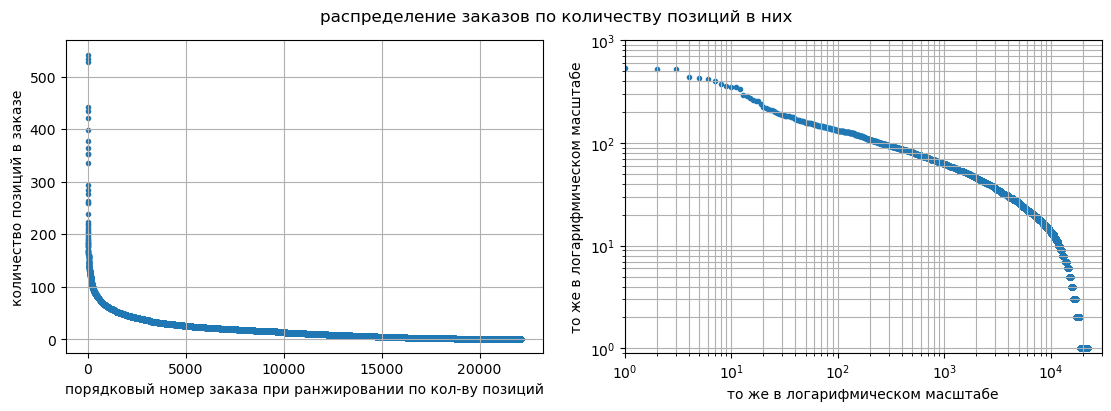

In [46]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,4), layout='constrained')

ax1.scatter(range(1,len(raw_df[fld].value_counts(dropna=False))+1), raw_df[fld].value_counts(dropna=False), marker='.')
ax2.scatter(range(1,len(raw_df[fld].value_counts(dropna=False))+1), raw_df[fld].value_counts(dropna=False), marker='.')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1,30000)
ax2.set_ylim(0.9,1000)

ax1.grid()
ax1.set_xlabel('порядковый номер заказа при ранжировании по кол-ву позиций')
ax1.set_ylabel('количество позиций в заказе')
ax2.grid(which='both')
ax2.set_xlabel('то же в логарифмическом масштабе')
ax2.set_ylabel('\nто же в логарифмическом масштабе')

plt.suptitle('распределение заказов по количеству позиций в них')
plt.show()

**все разумно и гладко - в районе от 100 позиций и выше на заказ, видимо, примешиваются организации, составляющие порядка 1/10 всех клиентов**

## Field 1: `StockCode`

In [47]:
fld = raw_df.columns[1]
raw_df[fld].map(len).value_counts(dropna=False).sort_index()

StockCode
1        536
2        134
3         16
4       1189
5     370178
6      33505
7        295
12        12
Name: count, dtype: int64

### поближе посмотрим на разнозначные примеры

In [48]:
raw_df['len_StockCode'] = raw_df.StockCode.map(len)

pd.DataFrame(
    index=['кол-во вариантов', 'значения вариантов'],
    data=[raw_df.groupby('len_StockCode').StockCode.nunique(), raw_df.groupby('len_StockCode').StockCode.unique()]
).T

,кол-во вариантов,значения вариантов
len_StockCode,,
1,2,"[D, M]"
2,1,[C2]
3,1,[DOT]
4,3,"[POST, PADS, CRUK]"
5,2798,"[71053, 22752, 21730, 22633, 22632, 84879, 227..."
6,877,"[85123A, 84406B, 84029G, 84029E, 82494L, 85099..."
7,1,[15056BL]
12,1,[BANK CHARGES]


**видим, что как и в случае номера чека, есть только два базовых варианта - 5 и 6 знаков**

#### по базовым вариантам предполагаем схожую ситуация как по номерам чеков:

In [49]:
raw_df.query('len_StockCode == 5').StockCode.map(str.isdecimal).value_counts()

StockCode
True    370178
Name: count, dtype: int64

**да, все пятизначные есть десятичные числа (целые)**

In [50]:
raw_df.query('len_StockCode == 6').StockCode.map(str.isdecimal).value_counts()

StockCode
False    33505
Name: count, dtype: int64

**да, все шестизначные содержат знаки, не использующиеся в десятичных числах**

In [51]:
raw_df.query('len_StockCode == 6').StockCode.map(lambda s: s[:-1].isdecimal()).value_counts()

StockCode
True    33505
Name: count, dtype: int64

**да, если убрать однобуквенный суффикс, то оставшиеся пять знаков есть десятичные числа (целые)**

In [52]:
raw_df.query('len_StockCode == 6').StockCode.map(lambda s: s[-1]).value_counts()

StockCode
B    9092
A    8474
C    4158
D    2337
L    1716
E    1561
F    1365
S    1271
G    1074
P     632
N     441
K     323
M     300
H     212
U     165
J     133
W     130
R      68
V      40
T       5
Y       3
I       3
O       1
Z       1
Name: count, dtype: int64

**в отличие от префиксов номеров заказов буквенные суффиксы разнообразны**

In [53]:
raw_df.query('len_StockCode == 5').sample(n=10, axis=0, random_state=11)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
339500,575329,23128,FELTCRAFT BOY JEAN-PAUL KIT,1,2011-11-09 13:50:00,4.95,17038,United Kingdom,5
153731,555737,21703,BAG 125g SWIRLY MARBLES,24,2011-06-07 09:19:00,0.42,16153,United Kingdom,5
67698,545063,22227,HANGING HEART MIRROR DECORATION,2,2011-02-27 14:26:00,0.65,14606,United Kingdom,5
160856,C556647,22502,PICNIC BASKET WICKER SMALL,-4,2011-06-13 16:14:00,5.95,13012,United Kingdom,5
42353,541981,20750,RED RETROSPOT MINI CASES,12,2011-01-24 15:32:00,6.35,12691,France,5
275190,569383,22191,IVORY DINER WALL CLOCK,4,2011-10-03 16:46:00,8.50,15159,United Kingdom,5
217515,563444,23013,GLASS APOTHECARY BOTTLE TONIC,1,2011-08-16 13:50:00,3.95,16033,United Kingdom,5
3139,536763,20973,12 PENCIL SMALL TUBE WOODLAND,48,2010-12-02 14:42:00,0.65,17685,United Kingdom,5
98228,548714,22859,EASTER TIN BUNNY BOUQUET,1,2011-04-03 15:07:00,1.65,17337,United Kingdom,5
396672,580688,23245,SET OF 3 REGENCY CAKE TINS,8,2011-12-05 15:38:00,4.95,15550,United Kingdom,5


In [54]:
raw_df.query('len_StockCode == 6').sample(n=10, axis=0, random_state=11)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
172395,558092,47504K,ENGLISH ROSE GARDEN SECATEURS,1,2011-06-26 12:54:00,1.95,14808,United Kingdom,6
219321,563613,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-08-18 08:49:00,0.85,12688,Israel,6
290059,570677,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12,2011-10-11 15:10:00,2.95,12836,United Kingdom,6
189946,560271,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2011-07-17 14:51:00,1.95,16474,United Kingdom,6
42579,541997,85049D,BRIGHT BLUES RIBBONS,6,2011-01-25 10:38:00,1.25,18077,United Kingdom,6
313424,572880,84596F,SMALL MARSHMALLOWS PINK BOWL,1,2011-10-26 13:35:00,0.42,16415,United Kingdom,6
256175,567656,79066K,RETRO MOD TRAY,2,2011-09-21 14:40:00,1.63,14096,United Kingdom,6
190779,560368,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,7,2011-07-18 12:25:00,2.10,17841,United Kingdom,6
4913,536993,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2010-12-03 15:19:00,2.95,14396,United Kingdom,6
306134,572219,85099B,JUMBO BAG RED RETROSPOT,2,2011-10-21 13:17:00,2.08,17463,United Kingdom,6


**по семантике буквенного суффикса в коде товара идей нет - может партнерский товар, может что-то еще**

#### вернемся к редким вариантам продуктовых кодов - которые назовем служебными

In [55]:
raw_df.query('len_StockCode not in [5,6]').StockCode.value_counts()

StockCode
POST            1170
M                459
15056BL          295
C2               134
D                 77
CRUK              16
DOT               16
BANK CHARGES      12
PADS               3
Name: count, dtype: int64

##### POST

In [56]:
raw_df.query('StockCode == "POST"').sample(n=10, axis=0, random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
32598,540642,POST,POSTAGE,7,2011-01-10 13:22:00,18.0,12681,France,4
390015,580120,POST,POSTAGE,1,2011-12-01 16:38:00,18.0,12553,France,4
238842,565931,POST,POSTAGE,2,2011-09-08 10:35:00,18.0,12683,France,4
37964,541430,POST,POSTAGE,18,2011-01-18 09:50:00,18.0,12356,Portugal,4
239926,566054,POST,POSTAGE,1,2011-09-08 15:04:00,18.0,12592,Germany,4
221403,563852,POST,POSTAGE,2,2011-08-19 15:18:00,15.0,12395,Belgium,4
270304,568994,POST,POSTAGE,2,2011-09-29 16:52:00,18.0,12598,France,4
182472,559441,POST,POSTAGE,2,2011-07-08 12:22:00,18.0,12583,France,4
95117,C548350,POST,POSTAGE,-1,2011-03-30 14:49:00,2.7,15648,United Kingdom,4
388022,579870,POST,POSTAGE,2,2011-11-30 16:47:00,18.0,12437,France,4


**совершенно очевидно, что это оплата почтовых отправлений покупок - это, конечно не разделит клиентов по предпочтениям, но возможно разделит их все равно. Однозначно, это не нарушит согласованности модели - ОСТАВЛЯЕМ**

##### M

In [57]:
raw_df.query('StockCode == "M"').sample(n=10, axis=0, random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
268673,C568799,M,Manual,-1,2011-09-29 10:34:00,2.88,17450,United Kingdom,1
26957,540021,M,Manual,1,2011-01-04 12:51:00,1.25,17841,United Kingdom,1
405497,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,1
81342,546742,M,Manual,12,2011-03-16 12:26:00,0.42,12849,United Kingdom,1
77920,C546325,M,Manual,-1,2011-03-11 10:15:00,1687.17,14911,EIRE,1
268672,C568799,M,Manual,-2,2011-09-29 10:34:00,90.00,17450,United Kingdom,1
61837,544464,M,Manual,4,2011-02-20 14:38:00,0.85,17323,United Kingdom,1
7021,537199,M,Manual,1,2010-12-05 14:06:00,0.65,15894,United Kingdom,1
308887,572423,M,Manual,1,2011-10-24 12:02:00,464.90,16742,United Kingdom,1
96529,C548543,M,Manual,-12,2011-03-31 18:44:00,3.75,14525,United Kingdom,1


**какие-то реконсилиации к заказам - это, конечно не разделит клиентов по предпочтениям, но возможно разделит их все равно. Есть риск отрицательных сумм всех заказов - пока ОСТАВЛЯЕМ**

##### 15056BL

In [58]:
raw_df.query('StockCode == "15056BL"').sample(n=10, axis=0, random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
145263,554701,15056BL,EDWARDIAN PARASOL BLACK,3,2011-05-26 09:33:00,5.95,12974,United Kingdom,7
127987,552574,15056BL,EDWARDIAN PARASOL BLACK,2,2011-05-10 12:20:00,5.95,15311,United Kingdom,7
241926,566258,15056BL,EDWARDIAN PARASOL BLACK,2,2011-09-11 12:45:00,5.95,13124,United Kingdom,7
96864,548610,15056BL,EDWARDIAN PARASOL BLACK,1,2011-04-01 11:28:00,5.95,15860,United Kingdom,7
27290,540093,15056BL,EDWARDIAN PARASOL BLACK,1,2011-01-04 15:24:00,5.95,16725,United Kingdom,7
100902,549101,15056BL,EDWARDIAN PARASOL BLACK,1,2011-04-06 11:34:00,5.95,14606,United Kingdom,7
49703,542904,15056BL,EDWARDIAN PARASOL BLACK,15,2011-02-01 14:58:00,5.95,12682,France,7
58595,544098,15056BL,EDWARDIAN PARASOL BLACK,3,2011-02-16 10:04:00,5.95,16019,United Kingdom,7
55628,543653,15056BL,EDWARDIAN PARASOL BLACK,2,2011-02-11 10:26:00,5.95,14796,United Kingdom,7
167661,557484,15056BL,EDWARDIAN PARASOL BLACK,5,2011-06-20 14:36:00,5.95,14796,United Kingdom,7


**гм, какие-то ретро-зонтики, может подарочные акции - ОСТАВЛЯЕМ**

##### C2

In [59]:
raw_df.query('StockCode == "C2"').sample(n=10, axis=0, random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
368586,578006,C2,CARRIAGE,1,2011-11-22 12:40:00,50.0,13363,United Kingdom,2
335169,574874,C2,CARRIAGE,1,2011-11-07 13:06:00,50.0,14911,EIRE,2
314488,572969,C2,CARRIAGE,1,2011-10-27 10:46:00,50.0,13363,United Kingdom,2
267890,568706,C2,CARRIAGE,1,2011-09-28 15:32:00,50.0,14911,EIRE,2
200961,561631,C2,CARRIAGE,1,2011-07-28 14:27:00,50.0,14911,EIRE,2
238207,565851,C2,CARRIAGE,1,2011-09-07 13:06:00,50.0,14911,EIRE,2
137130,553679,C2,CARRIAGE,1,2011-05-18 13:09:00,50.0,14565,United Kingdom,2
51798,543178,C2,CARRIAGE,1,2011-02-04 10:31:00,50.0,14911,EIRE,2
248441,566846,C2,CARRIAGE,1,2011-09-15 11:54:00,50.0,14911,EIRE,2
276347,569487,C2,CARRIAGE,1,2011-10-04 12:55:00,50.0,13351,United Kingdom,2


**похоже на доставку крупногабарита - ОСТАВЛЯЕМ как и почтовые расходы**

##### D

In [60]:
raw_df.query('StockCode == "D"').sample(n=10, axis=0, random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
155720,C556037,D,Discount,-1,2011-06-08 12:37:00,20.92,14527,United Kingdom,1
345327,C575872,D,Discount,-1,2011-11-11 12:52:00,97.14,13408,United Kingdom,1
71130,C545478,D,Discount,-720,2011-03-03 11:08:00,0.01,16422,United Kingdom,1
128330,C552650,D,Discount,-18,2011-05-10 14:03:00,1.45,16672,United Kingdom,1
230225,C564812,D,Discount,-1,2011-08-30 11:45:00,10.06,14527,United Kingdom,1
231323,C565075,D,Discount,-1,2011-08-31 17:25:00,36.30,13408,United Kingdom,1
388061,C579884,D,Discount,-1,2011-11-30 17:34:00,20.53,14527,United Kingdom,1
230767,C564909,D,Discount,-1,2011-08-31 12:29:00,66.17,15498,United Kingdom,1
20594,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422,United Kingdom,1
215769,C563225,D,Discount,-1,2011-08-14 14:35:00,434.51,14911,EIRE,1


**ну, дискаунт - он и в Африке дискаун, единственное, что бросается в глаза - а чего ж так редко!? ОСТАВЛЯЕМ**

##### CRUK

In [61]:
raw_df.query('StockCode == "CRUK"').sample(n=10, axis=0, random_state=13)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
298165,C571440,CRUK,CRUK Commission,-1,2011-10-17 13:31:00,495.98,14096,United Kingdom,4
341999,C575606,CRUK,CRUK Commission,-1,2011-11-10 12:37:00,517.51,14096,United Kingdom,4
351653,C576338,CRUK,CRUK Commission,-1,2011-11-14 15:27:00,1038.75,14096,United Kingdom,4
233629,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,13.01,14096,United Kingdom,4
264603,C568345,CRUK,CRUK Commission,-1,2011-09-26 15:28:00,447.56,14096,United Kingdom,4
288431,C570487,CRUK,CRUK Commission,-1,2011-10-10 17:12:00,411.92,14096,United Kingdom,4
310361,C572551,CRUK,CRUK Commission,-1,2011-10-24 17:07:00,425.14,14096,United Kingdom,4
372758,C578269,CRUK,CRUK Commission,-1,2011-11-23 13:39:00,849.93,14096,United Kingdom,4
245922,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,52.24,14096,United Kingdom,4
256295,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,608.66,14096,United Kingdom,4


In [62]:
raw_df.query('StockCode == "CRUK"').CustomerID.value_counts()

CustomerID
14096    16
Name: count, dtype: int64

**а клиент-то один, и это возвраты, существующие только для одного клиента 14096!**

In [63]:
raw_df.query('CustomerID == "14096"').InvoiceNo.value_counts()

InvoiceNo
576339     542
579196     533
580727     529
578270     442
573576     435
567656     421
575607     377
571441     364
570488     353
572552     352
568346     335
569246     285
566566      70
566217      34
565383      19
572854      14
564764       6
C564763      1
C570487      1
C569245      1
C567655      1
C568345      1
C566187      1
C565382      1
C566216      1
C566565      1
C575606      1
C573575      1
C571440      1
C572551      1
C578269      1
C576338      1
C579195      1
C580726      1
Name: count, dtype: int64

**один клиент погоды статистике не сделает, если только это не выброс - удалим 14096 совсем!**

In [64]:
raw_df = raw_df.query('CustomerID != "14096"').reset_index(drop=True).copy('deep')

##### DOT

In [65]:
raw_df.query('StockCode == "DOT"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode


**похоже, этот вариант отвалился вместе с 14096 - это точно особый клиент!**

##### BANK CHARGES

In [66]:
raw_df.query('StockCode == "BANK CHARGES"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
3205,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.000,15823,United Kingdom,12
38345,541505,BANK CHARGES,Bank Charges,1,2011-01-18 15:58:00,15.000,15939,United Kingdom,12
105640,549717,BANK CHARGES,Bank Charges,1,2011-04-11 14:56:00,15.000,14606,United Kingdom,12
122549,551945,BANK CHARGES,Bank Charges,1,2011-05-05 11:09:00,15.000,16714,United Kingdom,12
237057,565735,BANK CHARGES,Bank Charges,1,2011-09-06 12:25:00,15.000,16904,United Kingdom,12
263845,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,15.000,13405,United Kingdom,12
263846,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405,United Kingdom,12
300734,571900,BANK CHARGES,Bank Charges,1,2011-10-19 14:26:00,15.000,13263,United Kingdom,12
319840,573586,BANK CHARGES,Bank Charges,1,2011-10-31 14:48:00,15.000,14704,United Kingdom,12
327668,574546,BANK CHARGES,Bank Charges,1,2011-11-04 14:59:00,15.000,13651,United Kingdom,12


**ну, коммиссия банка - с этим все нормально, единственное, что бросается в глаза - а чего ж так редко!? ОСТАВЛЯЕМ**

##### PADS

In [67]:
raw_df.query('StockCode == "PADS"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
109732,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952,United Kingdom,4
198605,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618,United Kingdom,4
262321,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198,United Kingdom,4


**так, это бухгалтера выравнивают последний разряд - закон разрешает, кажется, до копейки.  Удаляем!**

In [68]:
raw_df = raw_df.query('StockCode != "PADS"').reset_index(drop=True).drop(columns=['len_StockCode']).copy('deep')

## Field 2: `Description`

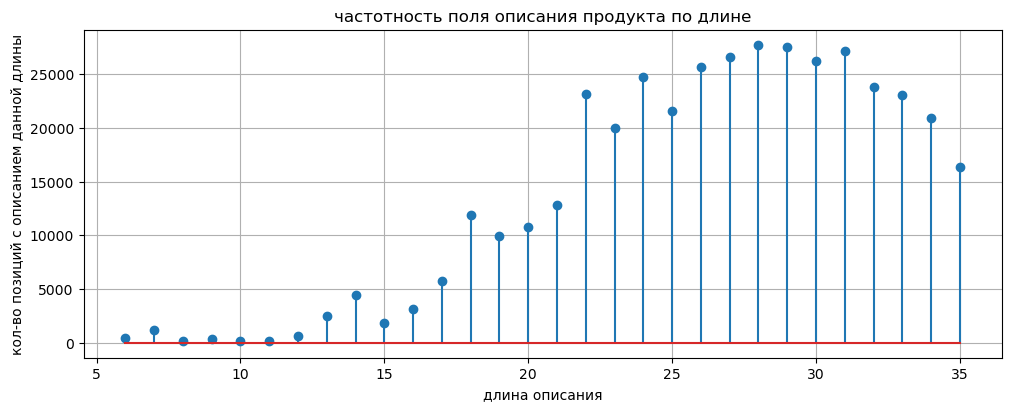

In [69]:
fld = raw_df.columns[2]

view_fld = raw_df[fld].map(len).value_counts(dropna=False).sort_index().reset_index()

plt.figure(figsize=(10,4), layout='constrained')

plt.stem(view_fld.iloc[:,0], view_fld.iloc[:,1])
plt.xlabel('длина описания')
plt.ylabel('кол-во позиций с описанием данной длины')
plt.title('частотность поля описания продукта по длине')

plt.grid()
plt.show()

## Field 3: `Quantity`

**как мы помним, отрицательные кол-ва находятся только в заказах с префиксом и наоборот:**

In [70]:
raw_df['has_prefix'] = raw_df.InvoiceNo.map(lambda s: s[0]=="C")
raw_df['is_negative'] = raw_df.Quantity.map(lambda n: n < 0)
raw_df[['has_prefix','is_negative']].value_counts()

has_prefix  is_negative
False       False          391861
True        True             8873
Name: count, dtype: int64

**это значит, что профили клиентов можно отдельно строить по заказам и по возвратам**

In [71]:
raw_df = raw_df.drop(columns=['has_prefix','is_negative']).copy('deep')  # чистим

## Field 4: InvoiceDate

**Основной вопрос к этому полю - что за время: локальное для клиента или глобальное время продавца (по Гринвичу).  Ответ даст анализ суточной активности в разных полушариях**

In [72]:
antipode_countries = ['Australia','USA','Singapore']

raw_df['hour'] = raw_df.InvoiceDate.map(str).map(lambda s: s.split()[1].split(':')[0]).map(lambda s: s[1] if s[0]=="0" else s).map(int)

### подготовим данные для красивого показа

In [73]:
uglysaxons = raw_df.query('Country == "United Kingdom"').hour.value_counts().sort_index().reset_index()
autochtones = raw_df.query('Country == "Australia"').hour.value_counts().sort_index().reset_index()
yankees = raw_df.query('Country == "USA"').hour.value_counts().sort_index().reset_index()
trans = raw_df.query('Country == "Singapore"').hour.value_counts().sort_index().reset_index()
gaulois = raw_df.query('Country == "France"').hour.value_counts().sort_index().reset_index()
bosch = raw_df.query('Country == "Germany"').hour.value_counts().sort_index().reset_index()

def add_missing_f(df):
    present = set(df.iloc[:,0])
    missing = [h for h in range(24) if h not in present]
    values = [0.01 for h in missing]

    df = pd.concat([df, pd.DataFrame(
                        index=df.columns,
                        data=[missing,values]
                        ).T], axis=0)
    return df.sort_values('hour')

uglysaxons = add_missing_f(uglysaxons)
autochtones = add_missing_f(autochtones)
yankees = add_missing_f(yankees)
trans = add_missing_f(trans)
gaulois = add_missing_f(gaulois)
bosch = add_missing_f(bosch)

### время шоу

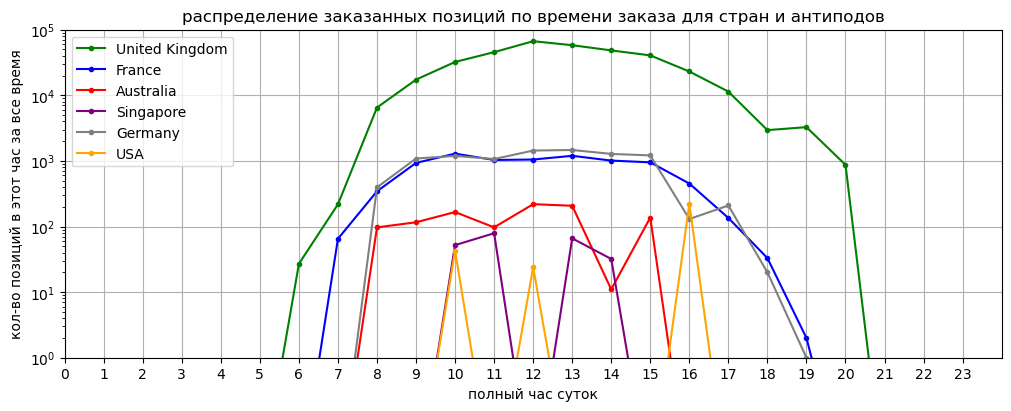

In [74]:
plt.figure(figsize=(10,4), layout='constrained')

plt.plot(uglysaxons.iloc[:,0], uglysaxons.iloc[:,1], color='green', marker='.', label='United Kingdom')
plt.plot(gaulois.iloc[:,0], gaulois.iloc[:,1], color='blue', marker='.', label='France')
plt.plot(autochtones.iloc[:,0], autochtones.iloc[:,1], color='red', marker='.', label='Australia')
plt.plot(trans.iloc[:,0], trans.iloc[:,1], color='purple', marker='.', label='Singapore')
plt.plot(bosch.iloc[:,0], bosch.iloc[:,1], color='gray', marker='.', label='Germany')
plt.plot(yankees.iloc[:,0], yankees.iloc[:,1], color='orange', marker='.', label='USA')

plt.yscale('log')
plt.ylim(1,100000)
plt.xlim(0,24)
plt.xticks(range(24))
plt.xlabel('полный час суток')
plt.ylabel('кол-во позиций в этот час за все время')
plt.title('распределение заказанных позиций по времени заказа для стран и антиподов')
plt.grid()
plt.legend()
plt.show()

**интересно, что интернет-магазин работает не круглосуточно!  Возможно, это связано с ограничениями банков в Англии на онлайн оплату с 21 вечера до 6 утра.  Причем такое ограничение, видимо, действует и на стороне банка клиента в его стране - мы видим, что чем более антиподными для Англии являются страны, тем короче окно совершения покупок.  Кроме того, возможно попадание разрыва суток - см. кривую по США**

### ВЫВОДЫ: время всегда берется по Гринвичу, что зашумляет определения суточных и недельных сезонностей до полусуток
**какова бы не была причина, но существуют объективные сложности для клиентов из стран-антиподов для покупок в данном магазине, и это может создать системный bias по их статистикам, поэтому страны с малым представлением и антиподы лучше удалить для снижения шумов - вернемся к этому, когда дойдем до поля Country**

In [75]:
raw_df = raw_df.drop(columns=['hour']).copy('deep')

## Field 5: `UnitPrice`

**как отмечалось в описании модели объекта, нам важно понимать вариативность цены одного продукта по странам и во времени**

In [76]:
raw_df.groupby('StockCode').UnitPrice.agg(['mean', 'std']).fillna(0.0).sort_values('std', ascending=False)

,mean,std
StockCode,,
M,339.295786,1949.423271
POST,38.213402,337.806769
D,72.484545,219.271071
22655,150.663043,67.163983
22656,143.653846,58.575724
...,...,...
21538,3.750000,0.000000
21467,3.750000,0.000000
84006,0.850000,0.000000


**ожидаемо большая вариативность у непродуктов - дискаунт, коррекции руками, почтовое отправление**

**посмотрим на статистику реальных продуктов с постоянной ценой и с переменной**

In [77]:
prices_all = raw_df[raw_df.StockCode.map(len).map(lambda n: n in [5,6])].groupby('StockCode').UnitPrice.agg(['mean', 'std']).fillna(0.0)

(len(prices_all[prices_all['std'] > 0.0]), len(prices_all[prices_all['std'] == 0.0]), 
 len(prices_all[prices_all['std'] > 0.0]) + len(prices_all[prices_all['std'] == 0.0]))

(2512, 1163, 3675)

**теперь тоже в рамках одной страны**

In [78]:
prices_UK = raw_df[raw_df.StockCode.map(len).map(lambda n: n in [5,6])].query('Country == "United Kingdom"').groupby(
    'StockCode').UnitPrice.agg(['mean', 'std']).fillna(0.0)
(len(prices_UK[prices_UK['std'] > 0.0]), len(prices_UK[prices_UK['std'] == 0.0]),
 len(prices_UK[prices_UK['std'] > 0.0]) + len(prices_UK[prices_UK['std'] == 0.0]))

(2347, 1305, 3652)

**даже только по одной стране примерно треть товаров не поменяла цены за исследуемый год, а две трети поменяли, причем вариативность усиливается если смотреть по всем странам.  Таким образом, цены на товары меняются во времени и между странами.  Еще одна причина оставить только UK - не известно, в каких единицах указываются цены в разных странах, маловероятно, что они приводятся к фунтам, к тому же курс также зависит от времени!**

## Field 6: `CustomerID`
это поле и есть объект дальнейшей кластеризации - о нем поговорим дальше! 

## Field 7: `Country`

In [79]:
fld = raw_df.columns[7]
view_fld = pd.DataFrame(raw_df[fld].value_counts(dropna=False))
view_fld['share_%'] = view_fld['count'] / (view_fld['count'].sum()) * 100
view_fld['cumul_share_%'] = view_fld['share_%'].cumsum()
view_fld

,count,share_%,cumul_share_%
Country,,,
United Kingdom,356723,89.017403,89.017403
Germany,9493,2.368903,91.386306
France,8490,2.118612,93.504918
EIRE,7483,1.867323,95.372242
Spain,2461,0.614123,95.986365
Netherlands,2367,0.590666,96.577031
Belgium,1819,0.453917,97.030948
Switzerland,1794,0.447679,97.478627
Portugal,1480,0.369322,97.847949


**как отмечали при EDA вопросов о локальном времени и о локальности цен - шумов будет меньше если оставить только UK, хотя сперва была идея резануть только до Австралии. Но то, что дорого в одной стране, недорого в другой и наоборот, поэтому, за неимением бизнес-причин учитывать разные страны с разным уровнем жизни, режем шумы по максимуму:**

In [80]:
raw_df = raw_df.query('Country == "United Kingdom"').reset_index(drop=True).drop(columns=['Country']).copy('deep')

## new Field 8: `Price`
поскольку цены на продукты изменчивы, то проще будет оперировать ценой позиции и количествами штук продукта

In [81]:
raw_df['Price'] = raw_df.Quantity * raw_df.UnitPrice
raw_df = raw_df.drop(columns=['UnitPrice']).copy('deep')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356723 entries, 0 to 356722
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356723 non-null  object        
 1   StockCode    356723 non-null  object        
 2   Description  356723 non-null  object        
 3   Quantity     356723 non-null  int64         
 4   InvoiceDate  356723 non-null  datetime64[ns]
 5   CustomerID   356723 non-null  object        
 6   Price        356723 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 19.1+ MB


# Агрегация датасета - финал предобработки данных

In [82]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356723 entries, 0 to 356722
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356723 non-null  object        
 1   StockCode    356723 non-null  object        
 2   Description  356723 non-null  object        
 3   Quantity     356723 non-null  int64         
 4   InvoiceDate  356723 non-null  datetime64[ns]
 5   CustomerID   356723 non-null  object        
 6   Price        356723 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 19.1+ MB


**вернемся к вопросу о дубликатах:**

In [83]:
print('FYI: полных дубликатов в данных все еще', raw_df.duplicated(keep=False).sum())

FYI: полных дубликатов в данных все еще 9920


**как было "согласовано с Заказчиком" в самом начале - их причины в повторном включении в один счет нескольких позиций по одному продукту.  Однако включения одного продукта возможны и с иным количеством и с иной ценой.  Теперь после предобработки все поля кроме количества и цены однозначная функция номера заказа или кода продукта, поэтому проверить сколько там еще неполных дубликатов по повторным включениям одного продукта в заказ можно так:**

In [84]:
print('FYI: повторных включений одного продукта в один заказ (включая полные дубликаты)в данных все еще', 
      raw_df.duplicated(subset=['InvoiceNo','StockCode'], keep=False).sum())

FYI: повторных включений одного продукта в один заказ (включая полные дубликаты)в данных все еще 18953


**наконец мы можем консолидировать все включения одного продукта в один заказ:**

In [85]:
prod_per_inv_df = raw_df.groupby(['InvoiceNo','StockCode'], as_index=False).agg({
    'Description':'first',
    'Quantity':'sum',
    'InvoiceDate':'first',
    'CustomerID':'first',
    'Price':'sum'
}).sort_values(['InvoiceDate','InvoiceNo','StockCode']).reset_index(drop=True).copy('deep')

prod_per_inv_df['client_start_date'] = prod_per_inv_df.groupby('CustomerID').InvoiceDate.transform('min')
prod_per_inv_df['client_stop_date'] = prod_per_inv_df.groupby('CustomerID').InvoiceDate.transform('max')
prod_per_inv_df['client_with_us'] = ((prod_per_inv_df['client_stop_date'] - prod_per_inv_df['client_start_date']) / 
                                     timedelta(days=1)).map(round)

prod_per_inv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346778 entries, 0 to 346777
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          346778 non-null  object        
 1   StockCode          346778 non-null  object        
 2   Description        346778 non-null  object        
 3   Quantity           346778 non-null  int64         
 4   InvoiceDate        346778 non-null  datetime64[ns]
 5   CustomerID         346778 non-null  object        
 6   Price              346778 non-null  float64       
 7   client_start_date  346778 non-null  datetime64[ns]
 8   client_stop_date   346778 non-null  datetime64[ns]
 9   client_with_us     346778 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 26.5+ MB


# Измерения кластеризации - нет смысла соединять все аспекты в один набор признаков: можно работать с вектором квантовых чисел -  номеров кластеров в разных смысловых плоскостях, относящихся к шаблонам поведенческой активности:
1) панельные признаки, включая частотные (интегральные по времени)
2) предпочтения по типам продуктов - LSA признаки по описаниям покупаемых продуктов
3) предпочтения по брендам - SVD координаты для таблицы StockCode vs CustomerID 
4) временной ряд активности

**остановимся на номерах 1 и 4 (а 2 и 3 будут в еще курсе Рекомендательных систем) и начнем, пожалуй**

## генерация таблицы панельных признаков

In [86]:
buy_client_df = prod_per_inv_df[prod_per_inv_df.InvoiceNo.map(len) == 6].groupby('CustomerID').agg({
    'InvoiceNo':'nunique',
    'StockCode':'nunique',
    'Quantity':'sum',
    'InvoiceDate':'unique',
    'Price':'sum',
    'client_with_us':'first'   
})
buy_client_df.columns = ['nof_invoices','nof_products','nof_pieces','buy_dates_list','total_sum','days_with_us']
buy_client_df = buy_client_df.sort_values('days_with_us').query('days_with_us > 0').query('nof_invoices > 1').reset_index()
buy_client_df['avg_invoice'] = buy_client_df['total_sum'] / buy_client_df['nof_invoices']       # добавим средний чек
buy_client_df['prod_price_level'] = buy_client_df['total_sum'] / buy_client_df['nof_pieces']    # и ценовую нишу товаров
buy_client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        2525 non-null   object 
 1   nof_invoices      2525 non-null   int64  
 2   nof_products      2525 non-null   int64  
 3   nof_pieces        2525 non-null   int64  
 4   buy_dates_list    2525 non-null   object 
 5   total_sum         2525 non-null   float64
 6   days_with_us      2525 non-null   int64  
 7   avg_invoice       2525 non-null   float64
 8   prod_price_level  2525 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 177.7+ KB


**походу дела мы также удалили клиентов, которые оставили слабый след в покупках:**
1) **менее 1 дня в логах магазина**
2) **менее 2 заказов**

In [87]:
buy_client_df.describe()

,nof_invoices,nof_products,nof_pieces,total_sum,days_with_us,avg_invoice,prod_price_level
count,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000
mean,6.013465,81.822178,1531.398416,2633.386947,207.209505,391.961649,2.096101
std,8.459832,91.571569,4334.721815,8974.452395,111.783709,1718.909928,6.047778
min,2.000000,1.000000,2.000000,6.900000,1.000000,3.450000,0.085619
25%,2.000000,28.000000,318.000000,612.080000,110.000000,190.400000,1.424221
50%,4.000000,56.000000,676.000000,1132.030000,218.000000,295.056667,1.788266
75%,7.000000,105.000000,1409.000000,2314.650000,307.000000,421.532000,2.237443
max,209.000000,1768.000000,80997.000000,259657.300000,373.000000,84236.250000,295.000000


**видим сильные перекосы распределений (кроме days_with_us), особенно для штук и сумм - что логнормально для человеческого потребления, посмотрим улучшит ли картину логарифм**

In [88]:
buy_client_df[['nof_invoices','nof_products','nof_pieces','total_sum','avg_invoice','prod_price_level']].map(np.log).describe()

,nof_invoices,nof_products,nof_pieces,total_sum,avg_invoice,prod_price_level
count,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000
mean,1.453632,3.931556,6.530537,7.111228,5.657597,0.580691
std,0.720907,1.063788,1.150591,1.060953,0.660139,0.446751
min,0.693147,0.000000,0.693147,1.931521,1.238374,-2.457847
25%,0.693147,3.332205,5.762051,6.416863,5.249127,0.353625
50%,1.386294,4.025352,6.516193,7.031768,5.687167,0.581246
75%,1.945910,4.653960,7.250636,7.747014,6.043896,0.805334
max,5.342334,7.477604,11.302167,12.467118,11.341381,5.686975


**да, логарифм все нормализует даже без боксов-коксов!  Но сперва дошьем в данные возвраты, где есть (так как там тоже будет логнормальность, но применить логарифм не дадут нули по тем, кто не возвращал!)**

In [89]:
return_client_df = prod_per_inv_df[prod_per_inv_df.InvoiceNo.map(len) == 7].groupby('CustomerID').agg({
    'StockCode':'nunique',
    'Quantity':'sum',
    'Price':'sum',
})
return_client_df.columns = ['products_back','pieces_back','money_back']
return_client_df = return_client_df.reset_index()
return_client_df

,CustomerID,products_back,pieces_back,money_back
0,12346,1,-74215,-77183.60
1,12748,44,-1538,-4647.63
2,12749,32,-49,-222.68
3,12822,1,-2,-29.90
4,12826,3,-4,-6.60
...,...,...,...,...
1405,18272,4,-6,-13.80
1406,18274,11,-88,-175.92
1407,18276,1,-2,-12.50
1408,18277,1,-1,-12.75


**сделаем левый джойн и заменим NaN-ы на нули**

In [90]:
client_df = buy_client_df.merge(return_client_df, how='left', on='CustomerID').fillna(0.0)
client_df.iloc[:,1:]

,nof_invoices,nof_products,nof_pieces,buy_dates_list,total_sum,days_with_us,avg_invoice,prod_price_level,products_back,pieces_back,money_back
0,4,81,263,"[2011-11-30 14:03:00, 2011-11-30 14:17:00, 201...",303.09,1,75.772500,1.152433,0.0,0.0,0.00
1,2,2,480,"[2011-06-28 12:21:00, 2011-06-29 09:58:00]",508.80,1,254.400000,1.060000,0.0,0.0,0.00
2,2,4,25,"[2011-04-27 16:39:00, 2011-04-28 15:58:00]",93.35,1,46.675000,3.734000,0.0,0.0,0.00
3,2,15,45,"[2011-06-30 19:52:00, 2011-07-01 15:07:00]",100.97,1,50.485000,2.243778,1.0,-3.0,-14.85
4,2,3,1040,"[2011-11-09 15:52:00, 2011-11-10 11:55:00]",1873.20,1,936.600000,1.801154,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2520,18,74,7559,"[2010-12-01 12:27:00, 2010-12-06 11:06:00, 201...",21086.30,372,1171.461111,2.789562,0.0,0.0,0.00
2521,37,184,2589,"[2010-12-01 15:08:00, 2010-12-06 13:34:00, 201...",5704.97,372,154.188378,2.203542,4.0,-8.0,-48.22
2522,33,36,12897,"[2010-12-01 16:01:00, 2010-12-01 16:11:00, 201...",25977.16,373,787.186667,2.014202,17.0,-93.0,-228.81
2523,91,567,38194,"[2010-12-01 09:41:00, 2010-12-05 13:55:00, 201...",60767.90,373,667.779121,1.591033,55.0,-474.0,-1348.56


**далее мы во-первых, переходим от абсолютных занчений к рейтам по времени - считая за время days_with_us, так как лучше идей нет, возвраты идея брать как долю от покупок по всем полям, а покупки нормализовать логарифмом - тогда хорошо нормализуются - останется только отскалировать к одному масштабу и все:**

In [91]:
freq_list = ['nof_invoices','nof_products','nof_pieces','total_sum','products_back','pieces_back','money_back']

for fld in freq_list:
    client_df[fld] = client_df[fld] / client_df['days_with_us']

client_df['money_back'] = client_df['money_back'] / client_df['total_sum']
client_df['pieces_back'] = client_df['pieces_back'] / client_df['nof_pieces']
client_df['products_back'] = client_df['products_back'] / client_df['nof_products']

for fld in freq_list[:4]+['avg_invoice','prod_price_level']:
    client_df[fld] = client_df[fld].map(np.log)

client_df.iloc[:,1:]

,nof_invoices,nof_products,nof_pieces,buy_dates_list,total_sum,days_with_us,avg_invoice,prod_price_level,products_back,pieces_back,money_back
0,1.386294,4.394449,5.572154,"[2011-11-30 14:03:00, 2011-11-30 14:17:00, 201...",5.714030,1,4.327735,0.141876,0.000000,0.000000,0.000000
1,0.693147,0.693147,6.173786,"[2011-06-28 12:21:00, 2011-06-29 09:58:00]",6.232055,1,5.538908,0.058269,0.000000,0.000000,0.000000
2,0.693147,1.386294,3.218876,"[2011-04-27 16:39:00, 2011-04-28 15:58:00]",4.536356,1,3.843209,1.317480,0.000000,0.000000,0.000000
3,0.693147,2.708050,3.806662,"[2011-06-30 19:52:00, 2011-07-01 15:07:00]",4.614823,1,3.921676,0.808161,0.066667,-0.066667,-0.147073
4,0.693147,1.098612,6.946976,"[2011-11-09 15:52:00, 2011-11-10 11:55:00]",7.535403,1,6.842256,0.588427,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2520,-3.028522,-1.614829,3.011600,"[2010-12-01 12:27:00, 2010-12-06 11:06:00, 201...",4.037485,372,7.066007,1.025885,0.000000,0.000000,0.000000
2521,-2.307976,-0.703958,1.940133,"[2010-12-01 15:08:00, 2010-12-06 13:34:00, 201...",2.730199,372,5.038175,0.790066,0.021739,-0.003090,-0.008452
2522,-2.425071,-2.338059,3.543172,"[2010-12-01 16:01:00, 2010-12-01 16:11:00, 201...",4.243395,373,6.668465,0.700223,0.472222,-0.007211,-0.008808
2523,-1.410719,0.418781,4.628855,"[2010-12-01 09:41:00, 2010-12-05 13:55:00, 201...",5.093239,373,6.503957,0.464383,0.097002,-0.012410,-0.022192


**проверим опять - вроде бы, неплохо:**

In [92]:
client_df.describe()

,nof_invoices,nof_products,nof_pieces,total_sum,days_with_us,avg_invoice,prod_price_level,products_back,pieces_back,money_back
count,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000
mean,-3.607185,-1.129261,1.469721,2.050412,207.209505,5.657597,0.580691,0.041639,-0.018165,-0.024505
std,0.847087,1.158451,1.161127,1.076489,111.783709,0.660139,0.446751,0.123380,0.075269,0.087980
min,-5.220356,-5.733341,-4.179502,-3.346593,1.000000,1.238374,-2.457847,0.000000,-1.551913,-2.181159
25%,-4.169246,-1.786845,0.721897,1.337811,110.000000,5.249127,0.353625,0.000000,-0.008573,-0.016136
50%,-3.713572,-1.120774,1.440362,1.990077,218.000000,5.687167,0.581246,0.000000,0.000000,0.000000
75%,-3.172483,-0.450201,2.150995,2.663545,307.000000,6.043896,0.805334,0.037594,0.000000,0.000000
max,1.791759,4.442651,8.622814,9.040541,373.000000,11.341381,5.686975,2.500000,0.000000,0.000000


**осталось извлечь из списка дат покупок привычки покупать в праздники**

In [93]:
cal = UnitedKingdom()

In [94]:
client_df['dayoff_share'] = client_df.buy_dates_list.map(lambda dt_lst: 1 - pd.Series([cal.is_working_day(dt) for dt in dt_lst]).mean())
client_df.dayoff_share.describe()

count    2525.000000
mean        0.133376
std         0.231276
min         0.000000
25%         0.000000
50%         0.000000
75%         0.200000
max         1.000000
Name: dayoff_share, dtype: float64

In [95]:
client_df = client_df.drop(columns=['buy_dates_list']).set_index('CustomerID').copy('deep')
client_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 15060 to 12748
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nof_invoices      2525 non-null   float64
 1   nof_products      2525 non-null   float64
 2   nof_pieces        2525 non-null   float64
 3   total_sum         2525 non-null   float64
 4   days_with_us      2525 non-null   int64  
 5   avg_invoice       2525 non-null   float64
 6   prod_price_level  2525 non-null   float64
 7   products_back     2525 non-null   float64
 8   pieces_back       2525 non-null   float64
 9   money_back        2525 non-null   float64
 10  dayoff_share      2525 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 236.7+ KB


In [96]:
scaler = StandardScaler()
norm_client_df = scaler.fit_transform(client_df)

norm_client_df = pd.DataFrame(
    index=client_df.index,
    columns=client_df.columns,
    data=norm_client_df
)

np.linalg.norm(norm_client_df, axis=0), np.linalg.norm(client_df, axis=0)

(array([50.24937811, 50.24937811, 50.24937811, 50.24937811, 50.24937811,
        50.24937811, 50.24937811, 50.24937811, 50.24937811, 50.24937811,
        50.24937811]),
 array([1.86187701e+02, 8.12845878e+01, 9.41121436e+01, 1.16363475e+02,
        1.18301196e+04, 2.86218667e+02, 3.68129109e+01, 6.54213791e+00,
        3.89007874e+00, 4.58839831e+00, 1.34135318e+01]))

In [97]:
np.sqrt(client_df.shape[0])

np.float64(50.24937810560445)

In [98]:
norm_client_df.index[0], norm_client_df.columns[0]

('15060', 'nof_invoices')

**табличный датасет для кластеризации по интегральным признакам готов!**

## генерация датасета временных рядов

In [99]:
prod_per_inv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346778 entries, 0 to 346777
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          346778 non-null  object        
 1   StockCode          346778 non-null  object        
 2   Description        346778 non-null  object        
 3   Quantity           346778 non-null  int64         
 4   InvoiceDate        346778 non-null  datetime64[ns]
 5   CustomerID         346778 non-null  object        
 6   Price              346778 non-null  float64       
 7   client_start_date  346778 non-null  datetime64[ns]
 8   client_stop_date   346778 non-null  datetime64[ns]
 9   client_with_us     346778 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 26.5+ MB


In [100]:
client_wlist = list(client_df.index)

In [101]:
client_ts = pd.DataFrame(
    index=client_wlist,
    data=[prod_per_inv_df.query('CustomerID == @cid').set_index('InvoiceDate').resample('D', origin='start_day').Price.sum(
         ) for cid in client_wlist]
).fillna(0.0)

In [102]:
client_ts.shape

(2525, 374)

In [103]:
client_ts

InvoiceDate,2010-12-01,2010-12-02,2010-12-03,2010-12-04,2010-12-05,2010-12-06,2010-12-07,2010-12-08,2010-12-09,2010-12-10,...,2011-11-30,2011-12-01,2011-12-02,2011-12-03,2011-12-04,2011-12-05,2011-12-06,2011-12-07,2011-12-08,2011-12-09
15060,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,286.48,16.61,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
17391,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
17991,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
16498,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
16986,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16210,2474.74,0.00,0.0,0.0,0.00,2263.80,0.00,0.00,0.00,0.00,...,788.46,0.00,0.00,0.0,0.00,0.00,0.00,0.0,3599.40,0.00
13468,360.05,0.00,0.0,0.0,0.00,222.18,0.00,0.00,0.00,0.00,...,0.00,-19.90,156.40,0.0,0.00,0.00,0.00,0.0,124.54,0.00
13777,6585.16,0.00,0.0,0.0,0.00,0.00,0.00,255.00,-42.00,0.00,...,-6.36,2251.51,0.00,0.0,0.00,0.00,0.00,0.0,0.00,265.24
15311,445.33,0.00,0.0,0.0,650.64,0.00,0.00,224.71,272.36,0.00,...,0.00,0.00,252.11,0.0,0.00,0.00,374.61,0.0,0.00,439.85


In [104]:
norm_client_ts = pd.DataFrame(
    columns = client_ts.columns,
    index = client_ts.index,
    data = (client_ts.values / (np.linalg.norm(client_ts, axis=1).reshape(client_ts.shape[0],-1)))
)

In [105]:
norm_client_ts.index[0], norm_client_ts.columns[0]

('15060', Timestamp('2010-12-01 00:00:00'))

In [106]:
print('FYI: несовпадений индексов',(norm_client_ts.index != norm_client_df.index).sum())

FYI: несовпадений индексов 0


In [107]:
np.linalg.norm(norm_client_ts, axis=1), np.linalg.norm(client_ts, axis=1),

(array([1., 1., 1., ..., 1., 1., 1.], shape=(2525,)),
 array([  286.9611167 ,   419.56722846,    87.64880205, ...,
        10453.62757682,  8768.02772873,  5716.82374269], shape=(2525,)))

**нормализованный (дает косинусную метрику при выборе эвклидовой) датасет временных рядов по ежедневной сумме покупки для того же списка клиентов, что в таблице интегральных признаков, - готов!**

# Кластеризация

## кластеризация по значениям временного ряда дневных выплат

### алгоритм KMeans с метрикой DTW

**код выше выполнялся 1400 секунд - из-за того, что в каждом цикле мы создаем новый инстанс объекта кластеризатора, каждый раз пересчитывая метрику DTW при вызове метода fit!  Оптимальнее было бы использовать tslearn только для однократного вычисления матрицы попарных DTW-расстояний, а потом использовать KMeans из sklearn, который "ест" внешнюю метрическую матрицу, для предварительных экспериментов с разными n**

**но, поскольку уж вычисления завершились - сохраним тут результаты для ускорения повторов:**

**выводим значения выше и копируем ниже**

In [108]:
distortions = [0.24748663555588693, 0.17788834355244026, 0.14719921377439515, 0.11882915436353664, 0.11177808332838388, 
               0.09975218577377361, 0.09169477455302537, 0.08684710150324046, 0.08357258577990428]
silhouette = [0.00035445102025659283, -0.0002887497013352045, -0.0014228304415115195, -0.0015093344191602367, 
              -0.0037790084130816205, -0.004898210004068079, -0.003327765542853176, -0.004856720311287714]
K = range(1, 10)

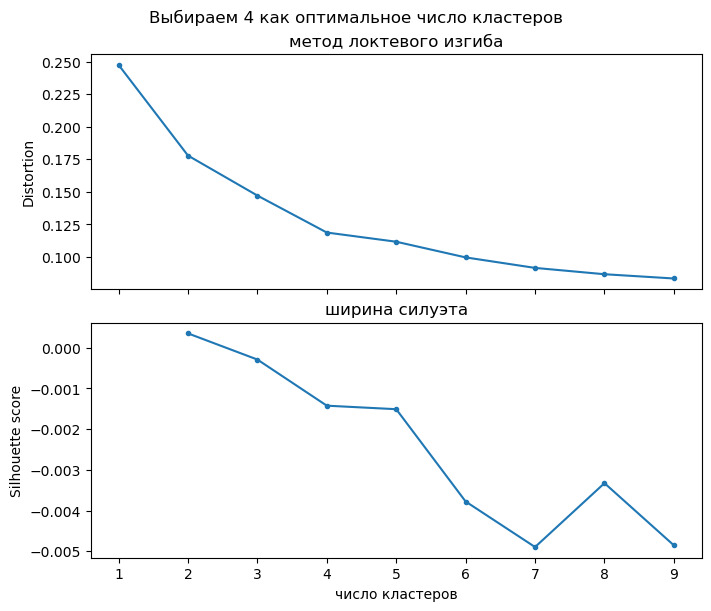

In [109]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(7,6), layout='constrained')

ax1.plot(K, distortions, marker='.')
ax1.set_ylabel('Distortion')
ax1.set_title('метод локтевого изгиба')

ax2.plot(K[1:], silhouette, marker='.')
ax2.set_xlabel('число кластеров')
ax2.set_ylabel('Silhouette score')
ax2.set_title('ширина силуэта')

fig.suptitle('Выбираем 4 как оптимальное число кластеров')
plt.show()

**с выбранным числом кластеров производим кластеризацию**

In [110]:
model_KMeans_DWT_n4 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=100, random_state=13)
result = model_KMeans_DWT_n4.fit_predict(norm_client_ts)

/home/GD/sevastyanov.a/anaconda3/envs/py31114_tsLearn_1/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/GD/sevastyanov.a/anaconda3/envs/py31114_tsLearn_1/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**восстановим соответствие номеров кластеров номерам клиентов**

In [111]:
clients_vs_clusters = pd.DataFrame(
    index=['dtw_cluster_no','CustomerID'],
    data=[result,norm_client_ts.index]
).T
clients_vs_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dtw_cluster_no  2525 non-null   object
 1   CustomerID      2525 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB


**посмотрим размеры кластеров**

In [112]:
print('Доля (%) клиентов в 4х кластерах по метрике DWT на временных рядах по дневным выплатам:')
(clients_vs_clusters.dtw_cluster_no.value_counts(normalize=True)*100).map(lambda fl: round(fl,2))

Доля (%) клиентов в 4х кластерах по метрике DWT на временных рядах по дневным выплатам:


dtw_cluster_no
3    28.36
1    24.99
2    24.63
0    22.02
Name: proportion, dtype: float64

**отличный результат: мечта любого маркетинга - идеальные четвертные сегменты рынка сбыта!  Посмотрим ключевые статистики по ним!**

In [113]:
view_stats = clients_vs_clusters.merge(client_df[['days_with_us','avg_invoice','prod_price_level',
                                                'total_sum','money_back','dayoff_share']].reset_index(
                                                ), how='left', on='CustomerID').copy('deep')
for fld in ['avg_invoice','prod_price_level','total_sum']:
    view_stats[fld] = view_stats[fld].map(np.exp) * view_stats.days_with_us
for fld in ['money_back','dayoff_share']:
    view_stats[fld] = (view_stats[fld]*100)

print('\nТАК ВЫГЛЯДИТ ТИПИЧНЫЙ ПРЕДСТАВИТЕЛЬ КАЖДОГО КЛАССА (агрегация по медианному значению)')
print('_'*90)
view_stats.drop(columns=['CustomerID']).groupby('dtw_cluster_no').agg('median').join(
              clients_vs_clusters.dtw_cluster_no.value_counts(normalize=True).sort_index()*100).map(round)


ТАК ВЫГЛЯДИТ ТИПИЧНЫЙ ПРЕДСТАВИТЕЛЬ КАЖДОГО КЛАССА (агрегация по медианному значению)
__________________________________________________________________________________________


,days_with_us,avg_invoice,prod_price_level,total_sum,money_back,dayoff_share,proportion
dtw_cluster_no,,,,,,,
0,116,28759,210,760,0,0,22
1,327,93143,550,3079,-1,8,25
2,156,37785,258,630,0,0,25
3,226,59895,389,1154,0,0,28


In [114]:
print('\nТАК ВЫГЛЯДИТ СРЕДНИЙ ВКЛАД ПРЕДСТАВИТЕЛЯ КАЖДОГО КЛАССА (агрегация по среднему значению)')
print('_'*90)
view_stats.drop(columns=['CustomerID']).groupby('dtw_cluster_no').agg('mean').join(
              clients_vs_clusters.dtw_cluster_no.value_counts(normalize=True).sort_index()*100).map(round)


ТАК ВЫГЛЯДИТ СРЕДНИЙ ВКЛАД ПРЕДСТАВИТЕЛЯ КАЖДОГО КЛАССА (агрегация по среднему значению)
__________________________________________________________________________________________


,days_with_us,avg_invoice,prod_price_level,total_sum,money_back,dayoff_share,proportion
dtw_cluster_no,,,,,,,
0,140,87981,281,2147,-4,12,22
1,301,118572,576,5761,-2,14,25
2,161,54061,316,952,-2,13,25
3,217,77140,428,1715,-2,15,28


**заметим, что различие классов по индивидуальному типичному поведению (по медианным значениям) сильнее, чем по усредненному вкладу "в общее дело" - что закономерно для метрики DTW, которая сравнивает индивидуальное поведение во времени, в отличие от эвклидовой метрики по интегральным признакам - см.далее**

## панельная кластеризация по интегральным признакам

**проверим утверждение, что самой простой способ кластеризации временных рядов - вытащить признаки и свести задачу к табличному (панельному) ML**

### PCA
**несмотря на то, что мы уже отскалировали панельные признаки по нулевой оси, мы все еще не знаем насколько они зависимы, поэтому будет полезно перейти к ортогональным координатам с помощью PCA-декомпозиции**

In [115]:
pca_obj = PCA(norm_client_df.shape[1])
X_pca = pca_obj.fit_transform(norm_client_df.values)

**посмотрим есть ли вырожденные степени свободы в панельных признаках**

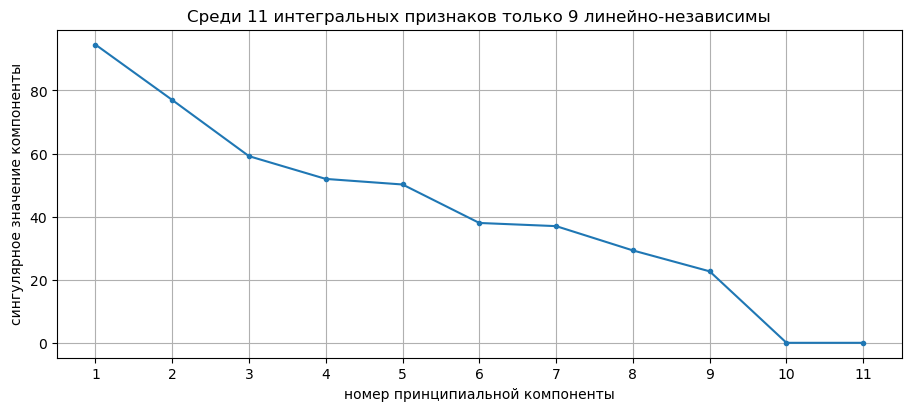

In [116]:
plt.figure(figsize=(9,4), layout='constrained')

plt.plot(range(1,norm_client_df.shape[1]+1), pca_obj.singular_values_, marker='.')
plt.xticks(range(1,norm_client_df.shape[1]+1))

plt.xlabel('номер принципиальной компоненты')
plt.ylabel('сингулярное значение компоненты')
plt.title('Среди 11 интегральных признаков только 9 линейно-независимы')

plt.grid()
plt.show()

In [117]:
model_AgglomCl_PCAnEUCL_n4 = AgglomerativeClustering(n_clusters=4, metric='euclidean')
result = model_AgglomCl_PCAnEUCL_n4.fit_predict(X_pca[:,:9])

In [118]:
clients_vs_clusters = clients_vs_clusters.merge(pd.DataFrame(
    index=['pca_cluster_no','CustomerID'],
    data=[result,norm_client_df.index]
).T, on='CustomerID')
clients_vs_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dtw_cluster_no  2525 non-null   object
 1   CustomerID      2525 non-null   object
 2   pca_cluster_no  2525 non-null   object
dtypes: object(3)
memory usage: 59.3+ KB


**опять сравним размеры кластеров**

In [119]:
print('Доля (%) клиентов в 4х кластерах по эвклидовой метрике на 9 PCA компонентах 11 интегральных признаков')
(clients_vs_clusters.pca_cluster_no.value_counts(normalize=True)*100).map(lambda fl: round(fl,2))

Доля (%) клиентов в 4х кластерах по эвклидовой метрике на 9 PCA компонентах 11 интегральных признаков


pca_cluster_no
2    47.37
1    37.82
3    10.18
0     4.63
Name: proportion, dtype: float64

**а тут классы гораздо сильнее разбалансированны и нумерация идет с синглета, так как сборка кластера агломеративным алгоритмом происходит снизу вверх по расстояниям.  Также смотрим ключевые статистики:**

In [120]:
view_stats = clients_vs_clusters.merge(client_df[['days_with_us','avg_invoice','prod_price_level',
                                                'total_sum','money_back','dayoff_share']].reset_index(
                                                ), how='left', on='CustomerID').copy('deep')
for fld in ['avg_invoice','prod_price_level','total_sum']:
    view_stats[fld] = view_stats[fld].map(np.exp) * view_stats.days_with_us
for fld in ['money_back','dayoff_share']:
    view_stats[fld] = (view_stats[fld]*100)

print('\nТАК ВЫГЛЯДИТ ТИПИЧНЫЙ ПРЕДСТАВИТЕЛЬ КАЖДОГО КЛАССА (агрегация по медианному значению)')
print('_'*90)
view_stats.drop(columns=['CustomerID','dtw_cluster_no']).groupby('pca_cluster_no').agg('median').join(
              clients_vs_clusters.pca_cluster_no.value_counts(normalize=True).sort_index()*100).map(round)


ТАК ВЫГЛЯДИТ ТИПИЧНЫЙ ПРЕДСТАВИТЕЛЬ КАЖДОГО КЛАССА (агрегация по медианному значению)
__________________________________________________________________________________________


,days_with_us,avg_invoice,prod_price_level,total_sum,money_back,dayoff_share,proportion
pca_cluster_no,,,,,,,
0,218,59962,390,1298,-22,0,5
1,252,54956,458,750,0,0,38
2,221,74949,323,1934,0,0,47
3,29,11060,47,959,0,0,10


In [121]:
print('\nТАК ВЫГЛЯДИТ СРЕДНИЙ ВКЛАД ПРЕДСТАВИТЕЛЯ КАЖДОГО КЛАССА (агрегация по среднему значению)')
print('_'*90)
view_stats.drop(columns=['CustomerID','dtw_cluster_no']).groupby('pca_cluster_no').agg('mean').join(
              clients_vs_clusters.pca_cluster_no.value_counts(normalize=True).sort_index()*100).map(round)


ТАК ВЫГЛЯДИТ СРЕДНИЙ ВКЛАД ПРЕДСТАВИТЕЛЯ КАЖДОГО КЛАССА (агрегация по среднему значению)
__________________________________________________________________________________________


,days_with_us,avg_invoice,prod_price_level,total_sum,money_back,dayoff_share,proportion
pca_cluster_no,,,,,,,
0,213,272094,458,6983,-29,7,5
1,245,62415,523,970,-1,18,38
2,212,96342,379,3785,-1,9,47
3,41,23068,68,1474,-1,22,10


# Визуализация результатов 
**в заключение выведем совместную кластеризацию в 2D и понагляднее покажем распределение признаков**

### сперва упорядочим нумерацию по обеим кластерным координатам так, чтобы максимально диагонализировать их популяции - для визуальной красоты

**на первом шаге упорядочим нумерацию независимо**

In [122]:
dtw_cl_dict = dict(zip(list(clients_vs_clusters.dtw_cluster_no.value_counts().index),range(4)))
pca_cl_dict = dict(zip(list(clients_vs_clusters.pca_cluster_no.value_counts().index),range(4)))

clients_vs_clusters.dtw_cluster_no = clients_vs_clusters.dtw_cluster_no.map(lambda n: dtw_cl_dict[n])
clients_vs_clusters.pca_cluster_no = clients_vs_clusters.pca_cluster_no.map(lambda n: pca_cl_dict[n])

confusion_matrix(clients_vs_clusters.dtw_cluster_no,clients_vs_clusters.pca_cluster_no)

array([[301, 337,  53,  25],
       [451, 145,  17,  18],
       [237, 295,  64,  26],
       [207, 178, 123,  48]])

**можно еще покрасивее переставить**

In [123]:
dtw_corr_dict = {1:0,2:3,3:2,0:1}
clients_vs_clusters.dtw_cluster_no = clients_vs_clusters.dtw_cluster_no.map(lambda n: dtw_corr_dict[n])
confusion_matrix(clients_vs_clusters.dtw_cluster_no,clients_vs_clusters.pca_cluster_no)

array([[451, 145,  17,  18],
       [301, 337,  53,  25],
       [207, 178, 123,  48],
       [237, 295,  64,  26]])

### далее нарисуем красиво в 2D

In [124]:
view_stats = clients_vs_clusters.merge(client_df[['days_with_us','avg_invoice','prod_price_level',
                                                'total_sum','money_back','dayoff_share']].reset_index(
                                                ), how='left', on='CustomerID').copy('deep')
for fld in ['avg_invoice','prod_price_level','total_sum']:
    view_stats[fld] = view_stats[fld].map(np.exp) * view_stats.days_with_us
for fld in ['money_back','dayoff_share']:
    view_stats[fld] = (view_stats[fld]*100)

flds_list = view_stats.columns[3:]

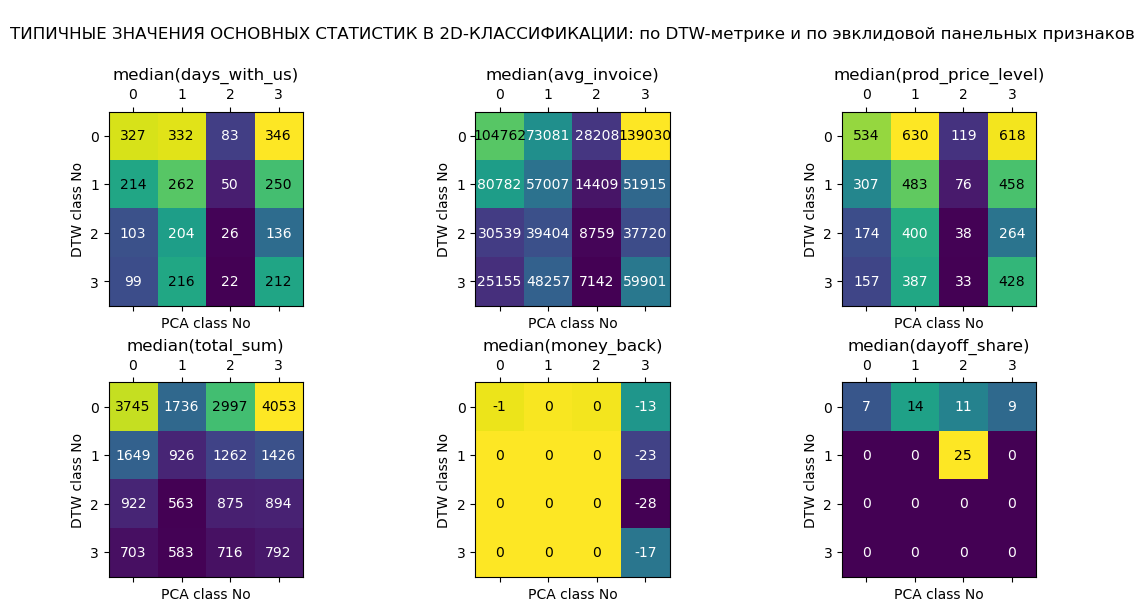

In [125]:
fig, ax = plt.subplots(2,3, figsize=(11,6), layout='constrained')
ax = ax.flatten()

for pic_no, pic_ax in enumerate(ax):
    show_mtrx = np.zeros((4,4))
    
    for i in range(4):
        for j in range(4):
            show_mtrx[i,j] = view_stats.query('dtw_cluster_no == @i & pca_cluster_no == @j')[flds_list[pic_no]].median()
            
            if show_mtrx[i,j] >= view_stats[flds_list[pic_no]].mean():
                color_choice = 'black'
            else:
                color_choice = 'white'
            
            pic_ax.annotate(round(show_mtrx[i,j]), xy=(j,i), color=color_choice, ha='center', va='center')

    pic_ax.matshow(show_mtrx)
    pic_ax.set_xlabel('PCA class No')
    pic_ax.set_ylabel('DTW class No')
    pic_ax.set_title('median('+flds_list[pic_no]+')')
    
fig.suptitle('\nТИПИЧНЫЕ ЗНАЧЕНИЯ ОСНОВНЫХ СТАТИСТИК В 2D-КЛАССИФИКАЦИИ: по DTW-метрике и по эвклидовой панельных признаков\n')
plt.show()

# <<<<< THE END >>>>>

In [126]:
ipynb_run_stop = datetime.now()
print('LAST RUN ON: ', str(ipynb_run_stop).split('.')[0])
print('total runtime =', round((ipynb_run_stop - ipynb_run_start).total_seconds(),1),'seconds')

LAST RUN ON:  2025-11-14 15:25:51
total runtime = 338.5 seconds
